In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch
from google.colab import drive
import os 
import os.path
import cv2
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = "drive/My Drive/nn_project/unit_size_images"

height = 64
width = 64

mapping_dict = {'team':0, 'squad':1, 'half-platoon':2, 'platoon':3, 'company':4, 'battalion':5}

images = np.empty((0, height, width))
labels = np.empty((0,))

image_urls = [os.path.join(PATH, image_name) for image_name in os.listdir(PATH)]


images = np.array([cv2.resize(cv2.imread(image_url, cv2.IMREAD_GRAYSCALE), (width, height), interpolation=cv2.INTER_AREA) for image_url in image_urls])
labels = np.array([mapping_dict[image_url.split('_')[-2]] for image_url in image_urls])

images = np.expand_dims(images, axis=1)
# images = np.delete(images, 0)
# labels = np.delete(labels, 0)

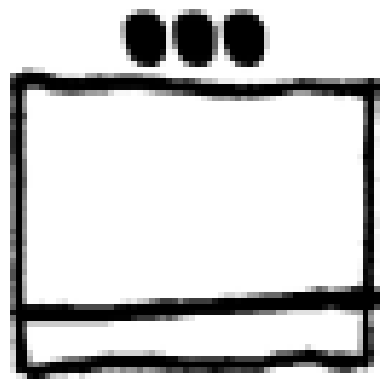

In [ ]:
plt.imshow(images[0][0], cmap='gray')
plt.axis('off') 
plt.show()

In [ ]:
images_tensor = torch.from_numpy(images)

In [ ]:

rotation_angles = 10
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(rotation_angles),
    transforms.ToTensor()
])

In [ ]:
images_augm = np.array([np.array(transform(image_tensor))*255 for image_tensor in images_tensor])
labels_augm = np.repeat(labels, repeats=1)

In [ ]:
images_final = np.concatenate((images, images_augm), axis=0)
labels_final = np.concatenate((labels, labels_augm), axis=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_final, labels_final, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).long()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=2, stride=1)
        self.bn1 = nn.BatchNorm2d(50)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(50)
        self.relu2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm2d(50)
        self.relu3 = nn.ReLU()
        self.conv3 = nn.Conv2d(50, 50, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(50)
        self.relu4 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8450, 1000)
        self.bn5 = nn.BatchNorm1d(1000)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1000, 100)
        self.bn6 = nn.BatchNorm1d(100)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(100, 6)
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu2(x)
      x = self.pool3(x)
      x = self.bn3(x)
      x = self.relu3(x)
      x = self.conv3(x)
      x = self.bn4(x)
      x = self.relu4(x)
      x = self.flatten(x)
      x = self.fc1(x)
      x = self.bn5(x)
      x = self.relu5(x)
      x = self.dropout1(x)
      x = self.fc2(x)
      x = self.bn6(x)
      x = self.relu6(x)
      x = self.dropout2(x)
      x = self.fc3(x)
      x = self.softmax(x)
      return x

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    """
    Function that trains a model using the provided DataLoader, loss function (criterion), and optimizer.
    It iterates through the mini-batches in the DataLoader, computes the model's output, calculates the loss, and updates the model's parameters using the optimizer.
    """
    model.train() 
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  

        outputs = model(inputs)  
        loss = criterion(outputs, targets) 

        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()  

    return running_loss / len(train_loader) 

In [ ]:
def validate(model, val_loader, criterion, device):
    """
    Function that evaluates a model on a validation dataset using the provided DataLoader and loss function (criterion). 
    """
    model.eval() 
    running_loss = 0.0

    with torch.no_grad(): 
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device) 

            outputs = model(inputs)
            loss = criterion(outputs, targets) 

            running_loss += loss.item()

    return running_loss / len(val_loader) 

In [ ]:
def calculate_accuracy(model, data_loader, device, calculate_predictions = False):
    """A function that calculate the accuracy of a model"""
    model.eval()  
    correct = 0
    total = 0

    predictions = np.empty((0,))

    with torch.no_grad():  
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
 
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            if calculate_predictions:
              predictions = np.concatenate((predictions, np.array(predicted.to("cpu"))), axis=0)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    return (accuracy, predictions)

In [ ]:
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
print(model)

MyModel(
  (conv1): Conv2d(1, 50, kernel_size=(2, 2), stride=(1, 1))
  (bn1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8450, out_features=1000, bias=True)
  (bn5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu5): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000

In [ ]:
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

num_epochs = 50

history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

for epoch in range(num_epochs):

    train_loss = train(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    train_accuracy, _ = calculate_accuracy(model, train_loader, device)
    history["train_accuracy"].append(train_accuracy)

    val_loss = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    val_accuracy, _  = calculate_accuracy(model, val_loader, device)
    history["val_accuracy"].append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print(f"Train accuracy: {train_accuracy:.4f} | Validation accuracy: {val_accuracy:.4f}")

Epoch 1/50
Train Loss: 1.6002 | Validation Loss: 1.6336
Train accuracy: 0.5232 | Validation accuracy: 0.3900
Epoch 2/50
Train Loss: 1.3470 | Validation Loss: 1.2725
Train accuracy: 0.9464 | Validation accuracy: 0.8838
Epoch 3/50
Train Loss: 1.1729 | Validation Loss: 1.1355
Train accuracy: 0.9821 | Validation accuracy: 0.9295
Epoch 4/50
Train Loss: 1.0950 | Validation Loss: 1.0900
Train accuracy: 0.9929 | Validation accuracy: 0.9627
Epoch 5/50
Train Loss: 1.0721 | Validation Loss: 1.0738
Train accuracy: 0.9982 | Validation accuracy: 0.9751
Epoch 6/50
Train Loss: 1.0682 | Validation Loss: 1.0626
Train accuracy: 0.9982 | Validation accuracy: 0.9876
Epoch 7/50
Train Loss: 1.0633 | Validation Loss: 1.0710
Train accuracy: 0.9982 | Validation accuracy: 0.9668
Epoch 8/50
Train Loss: 1.0553 | Validation Loss: 1.0657
Train accuracy: 1.0000 | Validation accuracy: 0.9751
Epoch 9/50
Train Loss: 1.0541 | Validation Loss: 1.0595
Train accuracy: 1.0000 | Validation accuracy: 0.9834
Epoch 10/50
Train L

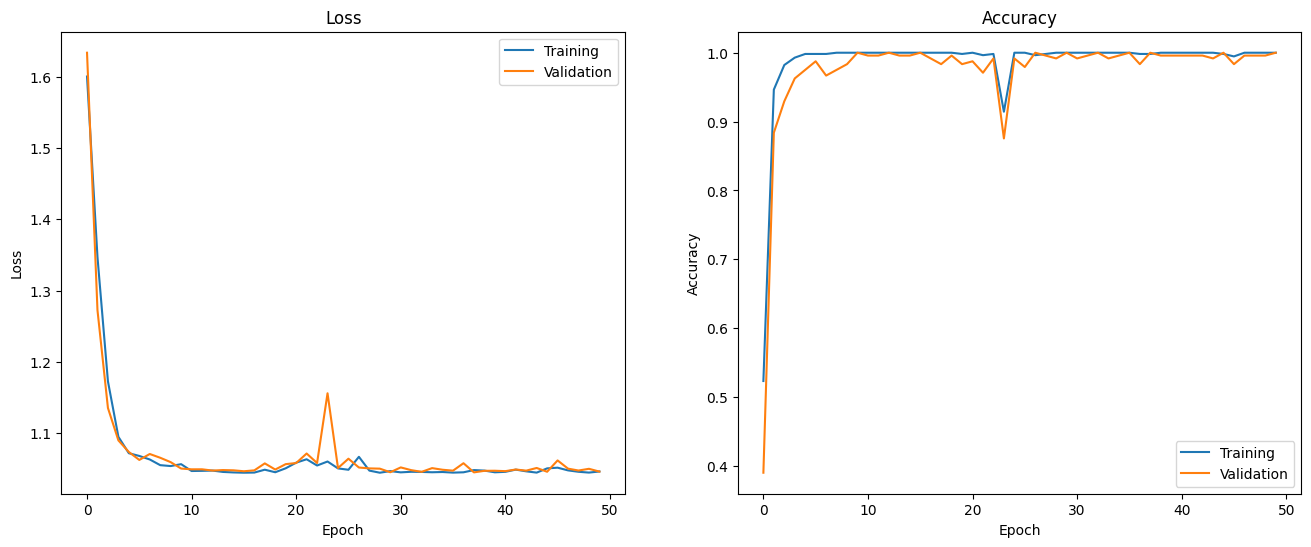

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history["train_accuracy"])
plt.plot(history["val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

plt.show()

In [ ]:
test_accuracy, test_predictions = calculate_accuracy(model, test_loader, device, calculate_predictions=True)
test_loss = validate(model, test_loader, criterion, device)
print("Test set accuracy:", test_accuracy)
print("Test loss:", test_loss)

Test set accuracy: 1.0
Test loss: 1.0441648851741443


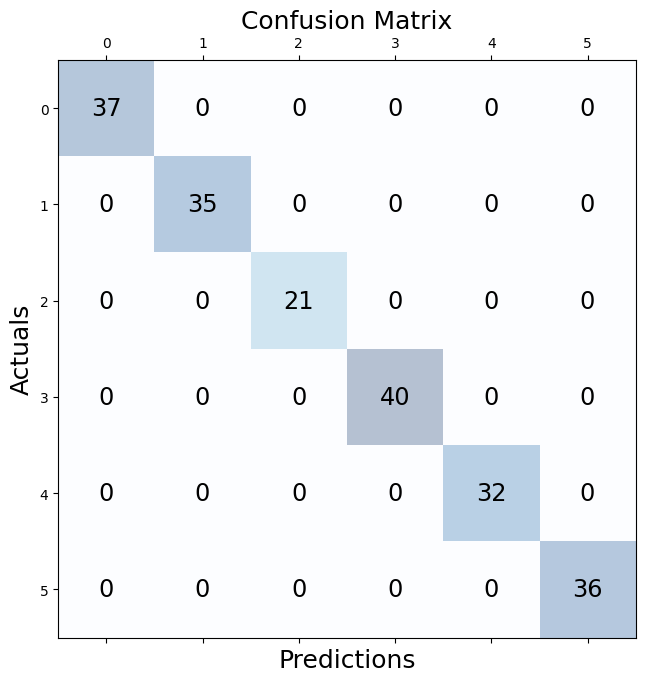

In [ ]:
from sklearn.metrics import confusion_matrix
y_test = np.array(y_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=test_predictions)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
scripted_model = torch.jit.script(model)
scripted_model.save('./model_unit_size.pt')